In [1]:
import math
import numpy as np
from IPython.display import clear_output
import pdb
import time
import matplotlib.pyplot as plt
import torch
from torch import Tensor
from torch import nn
from torch.nn  import functional as F 
from torch.autograd import Variable
from torchdiffeq import odeint_adjoint as odeint
from torch.distributions import MultivariateNormal
use_cuda = torch.cuda.is_available()
from geomloss import SamplesLoss
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import gc
import importlib
import Utils
importlib.reload(Utils)
from Utils import InputMapping, BoundingBox, ImageDataset, SaveTrajectory
from Utils import SaveTrajectory as st
import ODEModel
importlib.reload(ODEModel)
from ODEModel import ODEfunc, Siren
from ODEModel import FfjordModel
import LearnTraj
importlib.reload(LearnTraj);
from LearnTraj import learn_trajectory
import os;
import cv2 as cv;

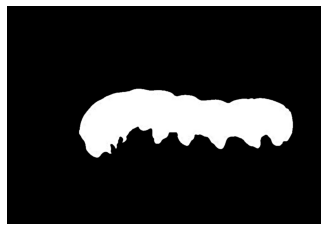

> d:\documents\wassflow\utils.py(73)__init__()
     71 #         np.convolve(img,xgrad.numpy())
     72         pdb.set_trace()
---> 73         edges = cv.Canny(img,0,0)
     74 #         edges = K.filters.canny(I2)[0]
     75 #         edges[edges>0]=1;



ipdb>  img.shape


(614, 884)


ipdb>  edges = cv.Canny(img,0,0)


*** cv2.error: OpenCV(4.5.4) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\canny.cpp:829: error: (-215:Assertion failed) _src.depth() == CV_8U in function 'cv::Canny'


ipdb>  img.shape


(614, 884)


ipdb>  torch.tensor(img).repeat(2,3).shape


torch.Size([1228, 2652])


ipdb>  torch.tensor(img).repeat(1,1,3).shape


torch.Size([1, 614, 2652])


ipdb>  torch.tensor(img).repeat(1,1,1,3).shape


torch.Size([1, 1, 614, 2652])


ipdb>  torch.tensor(img).repeat(1,3).shape


torch.Size([614, 2652])


ipdb>  torch.tensor(img).repeat(1,3,1).shape


torch.Size([1, 1842, 884])


ipdb>  torch.tensor(img).tile((1,1,3)).shape


torch.Size([1, 614, 2652])


ipdb>  torch.tensor(img).tile((3,1,1)).shape


torch.Size([3, 614, 884])


ipdb>  torch.permute(torch.tensor(img).tile((3,1,1)),(1,2,0)).shape


torch.Size([614, 884, 3])


ipdb>  cv.Canny(torch.permute(torch.tensor(img).tile((3,1,1)),(1,2,0)),0,0)


*** cv2.error: OpenCV(4.5.4) :-1: error: (-5:Bad argument) in function 'Canny'
> Overload resolution failed:
>  - image is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'image'
>  - Canny() missing required argument 'threshold2' (pos 4)
>  - Canny() missing required argument 'threshold2' (pos 4)


ipdb>  cv.Canny(torch.permute(torch.tensor(img).tile((3,1,1)),(1,2,0)).numpy(),0,0)


*** cv2.error: OpenCV(4.5.4) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\canny.cpp:829: error: (-215:Assertion failed) _src.depth() == CV_8U in function 'cv::Canny'


ipdb>  torch.permute(torch.tensor(img).tile((3,1,1)),(1,2,0)).numpy().shape


(614, 884, 3)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
caterpillar,im = ImageDataset.import_img('caterpillar.png'); caterpillar=1-caterpillar; caterpillar/=caterpillar.max();
butterfly,im = ImageDataset.import_img('butterfly.jpg'); butterfly=255-butterfly; butterfly/=butterfly.max();
circle,im = ImageDataset.import_img('circle.jpeg'); circle=255-circle; circle/=circle.max();
baldhead,im = ImageDataset.import_img('baldhead.jpeg'); baldhead=255-baldhead; baldhead/=baldhead.max();
square,im = ImageDataset.import_img('square.png', rgb_weights=[0.2989, 0.5870, 0.1140,0]); square=1-square; square/=square.max();
cat1,im = ImageDataset.import_img('cat1.png', rgb_weights = [0.2989, 0.5870, 0.1140, 1]); cat1/=cat1.max();
dset4 = ImageDataset(img=caterpillar*1,thresh=.8); 
# dset4 = ImageDataset(img=butterfly*1,thresh=.8)
# dset4 = ImageDataset(img=circle*1,thresh=.8)
# dset4 = ImageDataset(img=square*1,thresh=.8)
# dset5 = ImageDataset(img=cat1*1,thresh=.8)
# dset6 = ImageDataset(img=baldhead*1,thresh=.8)

n = 100000; 
# dat1 = dset1.sample(n); 
# dat2 = dset2.sample(n); 
# dat3 = dset3.sample(n)*.7;
# dat4 = dset4.sample(n);
# dat5 = dset5.sample(n);
# dat6 = dset6.sample(n);
dat4sil = dset4.samplesil(n);
# dat1*=-1; dat1[:,1]-=.1;
# dat2*=-1; dat2[:,1]+=.5; 
# dat3[:,1]+=1.5;
# dat5[:,1]*=-1;
# dat6[:,1]*=-1; dat6[:,1]+=.8;

# plt.scatter(dat1.detach().numpy()[:,0],dat1.detach().numpy()[:,1],s=10, alpha=0.5, linewidths=0,c='green') # butterfly
# plt.scatter(dat2.detach().numpy()[:,0],dat2.detach().numpy()[:,1],s=10, alpha=0.5, linewidths=0,c='red') # caterpillar
# plt.scatter(dat3.detach().numpy()[:,0],dat3.detach().numpy()[:,1],s=10, alpha=0.5, linewidths=0,c='magenta') # circle
# plt.scatter(dat4.detach().numpy()[:,0],dat4.detach().numpy()[:,1],s=10, alpha=0.5, linewidths=0,c='orange') # square
# plt.scatter(dat5.detach().numpy()[:,0],dat5.detach().numpy()[:,1],s=10, alpha=0.5, linewidths=0,c='yellow') # cat
# plt.scatter(dat6.detach().numpy()[:,0],dat6.detach().numpy()[:,1],s=10, alpha=0.5, linewidths=0,c='yellow') # face
# plt.scatter(dat4sil.detach().numpy()[:,0],dat4sil.detach().numpy()[:,1],s=10, alpha=0.5, linewidths=0,c='yellow') # squaresil
# plt.axis('equal')
# plt.show() 

0 255
0 255


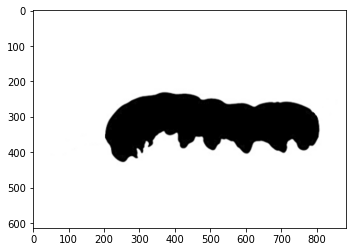

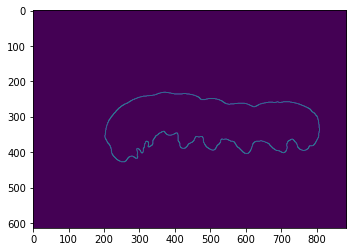

In [5]:
name = 'caterpillar.png'
# name = 'butterfly.jpg'
img = cv.imread(name);
edges = cv.Canny(img,50,200)
print(img.min(),img.max())
print(edges.min(),edges.max())
plt.imshow(img);plt.show()
plt.imshow(edges);plt.show()
i2 = img.copy()

training with sinkhorn_large_reg
lr 1e-06
batch 0 loss tensor(1., grad_fn=<AddBackward0>)


c:\users\paul\appdata\local\programs\python\python38\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


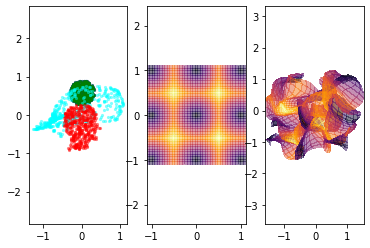

time elapsed 0.6387557983398438 total time 0.6377584934234619
batch number 0 out of 3000
savetime 0.0


KeyboardInterrupt: 

In [9]:
z_target = ImageDataset.normalize_samples(torch.stack((dat3, dat6)).to(device));
# usesiren = False; first_omega_0=20; sigmac = 10;
usesiren = True; first_omega_0=20; sigmac = 10;
model = Siren(first_omega_0=first_omega_0, usesiren = usesiren, sigmac = sigmac).to(device); 
bmodel = Siren(first_omega_0=first_omega_0, usesiren = usesiren, sigmac = sigmac).to(device); 
# model.load_state('models/seq_state420_time_31.615391731262207.tar');
# model.load_state('models/state310_time_22.49951934814453.tar');
# model.load_state('models/state_start.tar');
# for my_loss in ['sinkhorn_small_reg']:
# my_loss = 'sinkhorn_small_reg';
my_loss = 'sinkhorn_large_reg';
# %prun 
model, losses, separate_losses, lrs, n_subs = learn_trajectory(z_target, my_loss=my_loss,n_iters = 3000,n_subsample=500, model=model, bmodel=bmodel, save=True)

In [53]:
# st.gpu_usage()
# z_target.shape
# z_target = ImageDataset.normalize_samples(torch.stack((dat2, dat1)).to(device));

# torch.cuda.empty_cache()
# z_target = ImageDataset.normalize_samples(torch.stack((dat2, dat1)).to(device));
# model = FfjordModel().to(device); model.load_state('models/state_start.tar'); # print(next(model.parameters()).is_cuda)
# my_loss = 'sinkhorn_large_reg';
myln = my_loss+'_0';
st.save_trajectory(model,z_target[:,1:4000,:],myln, savedir='imgs', nsteps=20, memory=0.01, n=500,dpiv=400)
st.gpu_usage()
st.trajectory_to_video(myln, savedir='imgs', mp4_fn='transform.mp4')

# integration_times = torch.linspace(0,z_target.shape[0]-1,2).to(device);
# model(z_target[1,:,:], integration_times)


Allocated: 0.0 GB  Reserved: 0.0 GB


<Figure size 432x288 with 0 Axes>

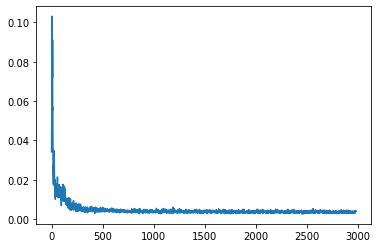

In [64]:
start=15;end=20000;
plt.plot(losses[start:end]); 
# plt.plot(separate_losses[0,start:end],'g'); 
# plt.plot(separate_losses[1,start:end],'r'); 
# plt.plot(separate_losses[2,start:end]); 
# plt.plot(separate_losses[3,start:end]*.01,'r'); 
# plt.plot(separate_losses[4,start:end]*10,'b'); 
# plt.plot(separate_losses[5,start:end]); 
# plt.plot(separate_losses[6,start:end]);
plt.savefig(os.path.join('./', f"viz_loss.jpg"),dpi=400); 

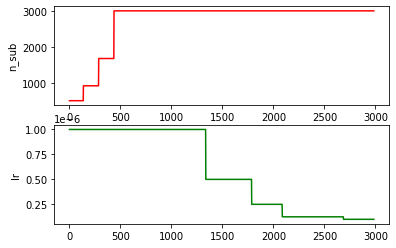

In [65]:
(fig,(ax1,ax2))=plt.subplots(2,1)
ax1.plot(n_subs[start:end],'r'); ax1.set_ylabel('n_sub')
ax2.plot(lrs[start:end],'g'); ax2.set_ylabel('lr') 
plt.savefig(os.path.join('./', f"viz_stat.jpg"),dpi=400); 

In [ ]:
torch.cuda.empty_cache() 
st.gpu_usage()

In [ ]:
# test what weights are given to what frequencies in the first layer
for param in model.parameters():
    print(type(param.data), param.size())
    pdat = param.data;
    break;    
pmags = torch.norm(param.data,p=2,dim=0);
freqs = model.time_deriv_func.imap.B;
nf = freqs.shape[0];
nd = (pmags.shape[0]-2*nf)

fmags = torch.norm(freqs,p=2,dim=1);
xyfreqs = torch.cat([fmags, fmags],dim=0);
print(xyfreqs.size())

plt.plot(xyfreqs.cpu().numpy(), pmags[0:(nf*2)].cpu().numpy(),'.')
plt.plot(np.zeros(nd), pmags[(nf*2):].cpu().numpy(),'.')
plt.savefig(os.path.join('./', f"viz_freqs.jpg"),dpi=400); 
# # freqs
# # fmags

In [ ]:
## visualize ending sinkhorn costs as gradient on point clouds
# z_target = ImageDataset.normalize_samples(torch.stack((dat1,dat4)).to(device));
T = z_target.shape[0];

z_t = model(z_target[0,:,:], integration_times = torch.linspace(0,T-1,T).to(device),reverse=False);
z_t_b = model(z_target[T-1,:,:], integration_times = torch.linspace(0,T-1,T).to(device),reverse=True);
forward = z_t[T-1,:,:].cpu().detach().numpy();
backward = z_t_b[T-1,:,:].cpu().detach().numpy();

my_loss_f = SamplesLoss("sinkhorn", p=2, blur=0.01);
loss_f = my_loss_f(z_target[T-1,:,:], z_t[T-1,:,:])
loss_b = my_loss_f(z_target[0,:,:], z_t_b[T-1,:,:])

graddirs_f = torch.autograd.grad(loss_f, z_t)[0][T-1,:,:]
graddirs_b = torch.autograd.grad(loss_b, z_t_b)[0][T-1,:,:]

pos_f = z_t.cpu().detach().numpy()
pos_b = z_t_b.cpu().detach().numpy()
dirs_f = graddirs_f.cpu().detach().numpy()
dirs_b = graddirs_b.cpu().detach().numpy()

import os
plt.axis('equal')
plt.scatter(pos_b[0,:,0], pos_b[0,:,1], s=10, alpha=.5, linewidths=0, c='green', edgecolors='black')
plt.scatter(forward[:,0], forward[:,1], s=10, alpha=.5, linewidths=0, c='red', edgecolors='black')
plt.quiver(pos_f[T-1,:,0], pos_f[T-1,:,1], dirs_f[:,0], dirs_f[:,1],scale=.0001)
plt.savefig(os.path.join('./', f"viz_backward.jpg"),dpi=400); plt.clf()

plt.axis('equal')
plt.scatter(pos_f[0,:,0], pos_f[0,:,1], s=10, alpha=.5, linewidths=0, c='green', edgecolors='black')
plt.scatter(backward[:,0], backward[:,1], s=10, alpha=.5, linewidths=0, c='red', edgecolors='black')
plt.quiver(pos_b[T-1,:,0], pos_b[T-1,:,1], dirs_b[:,0], dirs_b[:,1],scale=.0001)
plt.savefig(os.path.join('./', f"viz_forward.jpg"),dpi=400); 


In [ ]:
#trying other shapes

square = np.zeros([20,20])
square[6:14,:8] = 1

two_square = np.zeros([20,20])
two_square[:5,14:] = 1
two_square[15:,14:] = 1


annulus = import_img('annulus.png')
circle = 255-import_img('circle.jpeg')

dset = ImageDataset(img=square)
dset1 = ImageDataset(img=two_square)

n = 500
dat = dset.sample(n)
dat1 = dset1.sample(n)
plt.scatter(dat.detach().numpy()[:,0],dat.detach().numpy()[:,1],s=2.3, alpha=0.1, linewidths=5,c='green')
plt.scatter(dat1.detach().numpy()[:,0],dat1.detach().numpy()[:,1],s=2.3, alpha=0.1, linewidths=5,c='red')
plt.show() 

In [ ]:
# make half moon dataset
import sklearn.datasets

moons, labels = sklearn.datasets.make_moons(n,noise=.1) #generates two half moons
mask = (labels == 0)
one_moon = moons[mask,:] # only keep one moon

def rot_mat(theta0):
    #computes rotation matrix of angle theta
    return np.array([[np.cos(theta0),-np.sin(theta0)],[np.sin(theta0),np.cos(theta0)]])

theta0 = np.pi/2
theta1 = np.pi

rot0 = rot_mat(theta0)
rot1 = rot_mat(theta1)

# apply rotation to the moon
one_moon_rot0 = np.dot(one_moon,rot0)
one_moon_rot1 = np.dot(one_moon,rot1)

In [ ]:
#visualize rotated moons

plt.scatter(one_moon[:,0],one_moon[:,1], color='blue')
plt.scatter(one_moon_rot0[:,0],one_moon_rot0[:,1], color='orange')
plt.scatter(one_moon_rot1[:,0],one_moon_rot1[:,1], color='green')

In [ ]:
# with three timesteps

dat = torch.tensor(one_moon,dtype=torch.float)
dat0 = torch.tensor(one_moon_rot0,dtype=torch.float)
dat1 = torch.tensor(one_moon_rot1,dtype=torch.float)

dat_tuple = (dat,dat0,dat1)
z_target = torch.stack(dat_tuple).to(device)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for my_loss in ['sinkhorn_large_reg','sinkhorn_small_reg','energy_dist']:
    model = learn_trajectory(z_target, my_loss=my_loss,n_batch=500)
    save_trajectory(model,z_target,my_loss, savedir='imgs', nsteps=101, memory=0.01, n=1000)
    trajectory_to_video(my_loss)


In [ ]:
# with two timesteps


dat_tuple = (dat,dat0)
z_target = torch.stack(dat_tuple).to(device)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for my_loss in ['sinkhorn_large_reg','sinkhorn_small_reg','energy_dist']:
    model = learn_trajectory(z_target, my_loss=my_loss,n_batch=500)
    save_trajectory(model,z_target,my_loss, savedir='imgs', nsteps=101, memory=0.01, n=1000)
    trajectory_to_video(my_loss)


In [ ]:
losses